In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())
if torch.cuda.is_available():
    current_device = torch.cuda.current_device()
    print(f"Current device: {current_device}")
    print(f"Device name: {torch.cuda.get_device_name(current_device)}")
else:
    print("CUDA is not available.")

True
Current device: 0
Device name: Tesla P40


In [2]:
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1
        self.modes2 = modes2

        self.scale = 1 / (in_channels * out_channels)
        self.weights1 = nn.Parameter(self.scale * torch.randn(in_channels, out_channels, modes1, modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.randn(in_channels, out_channels, modes1, modes2, dtype=torch.cfloat))

    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x, y), (in_channel, out_channel, x, y) -> (batch, out_channel, x, y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        # Compute Fourier coefficients up to factor of e^(- something constant)
        x_ft = torch.fft.rfftn(x, dim=(-2, -1))

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize , self.out_channels, x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        # Return to physical space
        x = torch.fft.irfftn(out_ft, s=(x.size(-2), x.size(-1)))
        return x
        
class FNO2d(nn.Module):
    def __init__(self, input_size, output_size , modes1, modes2, width):
        super(FNO2d, self).__init__()

        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.padding = 9
        
        self.fc0 = nn.Linear(input_size, self.width)
        self.conv0 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)

        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.w3 = nn.Conv2d(self.width, self.width, 1)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, output_size)

    def forward(self, x):
        
        x = self.fc0(x)
        x = x.permute(2, 0, 1).unsqueeze(0)
        
        x = self.w0(x)
        x = torch.tanh(x)
        x = self.w1(x)
        x = torch.tanh(x)
        x = self.w2(x)
        x = torch.tanh(x)
        x = self.w3(x)
        x = torch.tanh(x)

        x = x.permute(0, 2, 3, 1)
        
        x = self.fc1(x)
        x = torch.tanh(x)
        x = self.fc2(x)
        return x

def fourier_derivatives(u, dx, dy):
    nx, ny = u.shape[-2], u.shape[-1]
    kx = torch.fft.fftfreq(nx, d=dx).to(u.device)
    ky = torch.fft.fftfreq(ny, d=dy).to(u.device)
    kx, ky = torch.meshgrid(kx, ky)
    
    
    
    u_xx = torch.fft.ifft2(-kx**2 * torch.fft.fft2(u)).real
    u_yy = torch.fft.ifft2(-ky**2 * torch.fft.fft2(u)).real

    return u_xx, u_yy

# Compute loss
def ui(x, y, model):
    u = model(torch.cat((x.unsqueeze(0) , y.unsqueeze(0)), dim=-1))
    return u


def loss_fn(x, y, model):
    u = ui(x, y, model)
    u_xx, u_yy = fourier_derivatives(u, 2 / (x.shape[-1] - 1), 2 / (y.shape[-1] - 1))
    f_pred = u_xx + u_yy
    f_exact = -torch.exp(-10 * (x**2 + y**2)) * (1 - 20 * x**2 + 1 - 20 * y**2)
    return torch.mean((f_pred - f_exact)**2)


Iteration 1000, Inf Norm: 7.990747690200806e-06, MSE: 0.035947, Time: 0.15s
Memory usage (u_new): 6.103515625e-05 MB
Iteration 2000, Inf Norm: 2.8423964977264404e-06, MSE: 0.035404, Time: 0.28s
Memory usage (u_new): 6.103515625e-05 MB
Iteration 3000, Inf Norm: 1.5795230865478516e-06, MSE: 0.035132, Time: 0.41s
Memory usage (u_new): 6.103515625e-05 MB
Iteration 4000, Inf Norm: 9.387731552124023e-07, MSE: 0.034972, Time: 0.54s
Memory usage (u_new): 6.103515625e-05 MB
Iteration 5000, Inf Norm: 5.699694156646729e-07, MSE: 0.034877, Time: 0.67s
Memory usage (u_new): 6.103515625e-05 MB
Iteration 6000, Inf Norm: 3.427267074584961e-07, MSE: 0.034819, Time: 0.80s
Memory usage (u_new): 6.103515625e-05 MB
Iteration 7000, Inf Norm: 2.086162567138672e-07, MSE: 0.034784, Time: 0.93s
Memory usage (u_new): 6.103515625e-05 MB
Iteration 8000, Inf Norm: 1.341104507446289e-07, MSE: 0.034763, Time: 1.07s
Memory usage (u_new): 6.103515625e-05 MB
Iteration 9000, Inf Norm: 8.195638656616211e-08, MSE: 0.034751

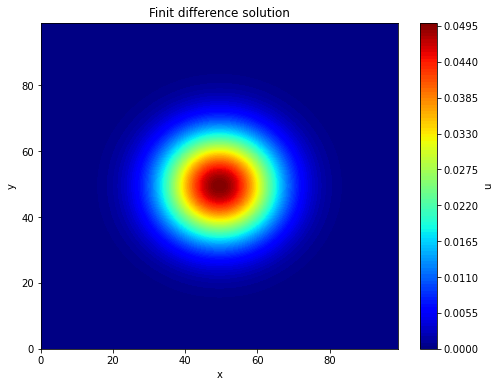

In [10]:
import torch
import time
import matplotlib.pyplot as plt
import sys

import psutil
import os



def get_memory_usage(obj):
    return sys.getsizeof(obj) / (1024 ** 2) 

#device = torch.device('cpu')
# Create a grid function
def create_grid(Lx, Ly, Nx, Ny, device):
    x = torch.linspace(-Lx, Lx, Nx, device=device)
    y = torch.linspace(-Ly, Ly, Ny, device=device)
    dx = torch.abs(x[1] - x[0])
    dy = torch.abs(y[1] - y[0])
    return x, y, dx, dy

# Define the source function
def source_function(x, y):
    return -torch.exp(-10 * (x**2 + y**2)) * (1 - 20 * x**2 + 1 - 20 * y**2)

# Solve the Poisson equation
def solve_poisson_equation(Lx, Ly, Nx, Ny, source_func, max_iter=3000, tol=1e-5):
    #device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    device = torch.device('cpu')
    start = time.time()
    torch.cuda.empty_cache()
    
    x, y, dx, dy = create_grid(Lx, Ly, Nx, Ny, device)
    u = torch.zeros((Nx, Ny), device=device)
    u[:, 0] = torch.exp(-10 * (x**2 + 1))
    u[0, :] = torch.exp(-10 * (y**2 + 1))
    u[:, -1] = torch.exp(-10 * (x**2 + 1))
    u[-1, :] = torch.exp(-10 * (y**2 + 1))
    
    x, y = torch.meshgrid(x, y)
    f = source_func(x, y)
    u_ex = torch.exp(-10 * (x**2 + y**2))
    U = []
    mse = 1
    h = 0
    for h in range(max_iter):
    #while mse > 1e-4 :
        h += 1
        u_new = u.clone()
        u_new[1:-1, 1:-1] = ((u[2:, 1:-1] + u[:-2, 1:-1]) * dy**2 +
                             (u[1:-1, 2:] + u[1:-1, :-2]) * dx**2 -
                             dx**2 * dy**2 * f[1:-1, 1:-1]) / (2 * (dx**2 + dy**2))
        
        # Check for convergence
        if torch.norm(u - u_new, p=float('inf')).item() < tol :
            print(f'Converged in {h+1} iterations')
            break
        
        if h % 1000 == 0:
            local_end = time.time()
            eps = torch.norm(u - u_new, p=float('inf')).item()
            print(f'Iteration {h}, Inf Norm: {eps}, MSE: {torch.mean((u - u_ex)**2):.6f}, Time: {local_end - start:.2f}s')
            print(f"Memory usage (u_new): {get_memory_usage(u_new)} MB")
        u = u_new
        U.append(u_new.flatten().unsqueeze(0))
    
    U = torch.cat(U, dim=0)
    end = time.time()
    print(f"Time taken: {end - start} seconds")
    
    return u.cpu().numpy(), U, end - start

# Example usage
Lx = 1
Ly = 1
Nx = 100
Ny = 100
max_iter = 20000
tol = 1e-10

u_solution, U, time_taken = solve_poisson_equation(Lx, Ly, Nx, Ny, source_function, max_iter, tol)

# Visualize the solution
plt.figure(figsize=(8, 6))
plt.contourf(u_solution,levels = 100, cmap='jet')
plt.colorbar(label='u')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Finit difference solution')
plt.show()


In [7]:
def create_grid(Lx, Ly, Nx, Ny, device):
    x = torch.linspace(-1, Lx, Nx, device=device)
    y = torch.linspace(-1, Ly, Ny, device=device)
    dx = torch.abs(x[0]-x[1])
    dy = torch.abs(y[0]-y[1])
    #x,y = torch.meshgrid(x, y)
    return x,y,dx,dy

def source_function(x, y):
    return -torch.exp(-10 * (x**2 + y**2)) * (1 - 20 * x**2 + 1 - 20 * y**2)

def solve_poisson_equation(Lx, Ly, Nx, Ny, source_func, max_iter=3000, tol=1e-5):
    

    start = time.time()
    

    # Initialize the solution array and set boundary conditions
    u = torch.zeros((Nx, Ny), device=device)
    x, y,dx,dy = create_grid(Lx, Ly, Nx, Ny, device)
    
    
    u[:, 0] = torch.exp(-10*(x**2+1))
    u[0, :] = torch.exp(-10*(y**2+1))

    # Boundary conditions
    #u_boundary1 = torch.sin(x[:, 0]) / torch.sin(torch.tensor(9))
    #u_boundary2 = torch.sinh(y[0, :]) / torch.sinh(torch.tensor(4))

    # Apply boundary conditions to the solution array
    u[:, -1] = torch.exp(-10*(x**2+1))
    u[-1, :] = torch.exp(-10*(y**2+1))
    U = []
    # Source function
    x,y = torch.meshgrid(x,y)
    f = source_func(x, y)
    u_ex = torch.exp(-10 * (x**2 + y**2))

    # Solve the Poisson equation
    for h in range(max_iter):
        u_new = u.clone()
        for i in range(1, Nx - 1):
            for j in range(1, Ny - 1):
                u_new[i, j] = ((u[i+1, j] + u[i-1, j]) * dy**2 +
                               (u[i, j+1] + u[i, j-1]) * dx**2 - 
                               dx**2 * dy**2 * f[i, j]) / (2 * (dx**2 + dy**2))
        
        # Check for convergence
        if torch.norm(u - u_new, p=float('inf')).item() < tol:
            print(f'Converged in {h+1} iterations')
            break
        if h%100 == 0:
            local_end = time.time()
            eps = torch.norm(u - u_new, p=float('inf')).item()
            print(eps)
            mse = torch.mean((u- u_ex)**2)
            print(mse ,local_end-start)
        u = u_new
        U.append(u_new.flatten().unsqueeze(0))
           
    U = torch.cat(U, dim=0)
    end = time.time()
    print(f"Time taken: {end - start} seconds")
    
    return u.cpu().numpy(), U, end - start

# Example usage
Lx = 1
Ly = 1
Nx = 40
Ny = 40
max_iter = 400
tol = 1e-5

u_solution,U, time_taken = solve_poisson_equation(Lx, Ly, Nx, Ny, source_function, max_iter, tol)

# Visualize the solution
plt.contourf(u_solution, cmap='jet')
plt.colorbar(label='u')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Solution to the Poisson Equation')
plt.show()

0.001280682859942317
tensor(0.0373, device='cuda:0') 0.2516467571258545


KeyboardInterrupt: 

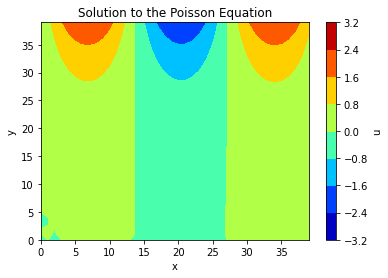

In [7]:
plt.contourf(u_solution.T, cmap='jet')
plt.colorbar(label='u')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Solution to the Poisson Equation')
plt.show()

In [3]:
# Define the grid and source function
def create_grid(nx, ny):
    x = torch.linspace(-1, 1, nx).to(device)
    y = torch.linspace(-1, 1, ny).to(device)
    return torch.meshgrid(x, y)

def source_function(x, y):
    return torch.zeros_like(x) #* torch.sin(np.pi * y) #-torch.exp(-10 * (x**2 + y**2)) #* (1 - 20 * x**2 + 1 - 20 * y**2)

# Finite Difference Method for Poisson Equation
def solve_poisson_fd(nx, ny, num_iter=100):
    # Grid spacing
    hx = 1 / (nx - 1)
    hy = 1 / (ny - 1)
    
    # Create grid and source function
    
    x, y = create_grid(nx, ny)
    f = source_function(x, y)
    u =  torch.zeros((nx, ny)).to(device)#ui(x, y ,model).reshape(nx,ny)
    x = torch.linspace(-1, 1, nx).to(device)
    y = torch.linspace(-1, 1, ny).to(device)
    # Initialize u
    U = []
    
    for i in range(num_iter):
        u_new = torch.clone(u)
        u_new[1:-1, 1:-1] = 0.25 * (u[2:, 1:-1] + u[:-2, 1:-1] + u[1:-1, 2:] + u[1:-1, :-2]  - hx * hy * f[1:-1, 1:-1])
        
        # Enforce boundary conditions (Dirichlet boundary conditions in this case)
        u_new[:, 0] = 0 #torch.exp(-10*(x**2+1))
        u_new[:, -1] = torch.sin(y)/torch.sin(torch.tensor(9))#torch.exp(-10*(y**2+1))
        u_new[0, :] = 0 #torch.exp(-10*(x**2+1))
        u_new[-1, :] =  torch.sinh(x)/torch.sinh(torch.tensor(4))#torch.exp(-10*(y**2+1))
        
        u = u_new

        
        U.append(u_new.flatten().unsqueeze(0))
           
    U = torch.cat(U, dim=0)
    return U[-1], U

# Parameters
nx, ny = 100, 100

start = time.time()
# Solve Poisson equation
u_solution ,U = solve_poisson_fd(nx, ny)
end = time.time()
print(end - start)
# Convert to CPU for plotting if needed
u_cpu = u_solution.cpu().detach().numpy()
x = np.linspace(0, 9, nx)
y = np.linspace(0, 4, ny)
x,y =  np.meshgrid(x, y)
x,y = x.flatten() , y.flatten()
mse = np.mean((u_cpu- np.exp(-10 * (x**2 + y**2)))**2 )
print(mse ,U.shape)


RuntimeError: CUDA error: out of memory

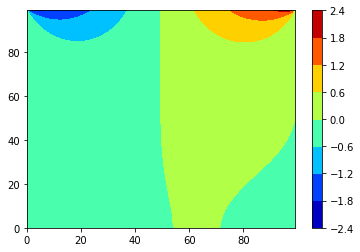

In [5]:
import matplotlib.pyplot as plt
plt.contourf(u_solution.cpu().detach().numpy().reshape(nx, ny).T, cmap='jet')
plt.colorbar()

In [9]:
from torch.cuda.amp import GradScaler, autocast

device = torch.device('cpu')
# Define the grid and source function
def create_grid(nx, ny):
    x = torch.linspace(-1, 1, nx).to(device)
    y = torch.linspace(-1, 1, ny).to(device)
    return torch.meshgrid(x, y)

def source_function(x, y):
    return -torch.exp(-10 * (x**2 + y**2)) * (1 - 20 * x**2 + 1 - 20 * y**2)

# Finite Difference Method for Poisson Equation
def solve_poisson_fd(nx, ny, num_iter=1000):
    # Grid spacing
    hx = 1 / (nx - 1)
    hy = 1 / (ny - 1)
    
    # Create grid and source function
    
    x, y = create_grid(nx, ny)
    f = source_function(x, y)
    u =  torch.zeros((nx, ny)).to(device)#ui(x, y ,model).reshape(nx,ny)
    x = torch.linspace(-1, 1, nx).to(device)
    y = torch.linspace(-1, 1, ny).to(device)
    # Initialize u
    U = []
    print('i')
    for i in range(num_iter):
        u_new = torch.clone(u)
        u_new[1:-1, 1:-1] = 0.25 * (u[2:, 1:-1] + u[:-2, 1:-1] + u[1:-1, 2:] + u[1:-1, :-2] - hx * hy * f[1:-1, 1:-1])
        
        # Enforce boundary conditions (Dirichlet boundary conditions in this case)
        u_new[:, 0] = torch.exp(-10*(x**2+1))
        u_new[:, -1] = torch.exp(-10*(y**2+1))
        u_new[0, :] = torch.exp(-10*(x**2+1))
        u_new[-1, :] = torch.exp(-10*(y**2+1))
        
        u = u_new

        if i% 100 == 0:
            U.append(u_new.unsqueeze(0))
            print(i)
    U = torch.cat(U, dim=0)
    return U[-1], U

def build_sequences(u, sequence_lenght= 50):
  sequences = []
  target = []
  for i in range(len(u) - sequence_lenght):
    sequences.append(u[i:i+sequence_lenght].cpu())
    target.append(u[i+sequence_lenght].cpu())

  sequences = np.stack(sequences)
  target = np.stack(target)
    
  X_train, X_test, y_train, y_test = train_test_split(sequences, target, test_size=0.2, random_state=42)
   
  X_train = torch.tensor(X_train).to(device)
  y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
  X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
  y_test = torch.tensor(y_test, dtype=torch.float32).to(device)
  
  train_dataset = TensorDataset(X_train, y_train)
  test_dataset = TensorDataset(X_test, y_test)
  return train_dataset, test_dataset

class TransformerModel(nn.Module):
    def __init__(self, input_size, d_model, nhead, num_encoder_layers, dim_feedforward, output_size):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_size, d_model)
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward),
            num_encoder_layers
        )
        self.fc = nn.Linear(d_model, output_size)
    
    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer_encoder(x)
        x = torch.tanh(x.mean(dim=1))
        x = self.fc(x)
        return x
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        #out = torch.tanh(out[:, -1, :])
        out = self.fc(out[:, -1, :])
        return out
    
"""def f(x, y ,model):
    
    x.requires_grad_(True)
    y.requires_grad_(True)
    grid = torch.stack((x.flatten(),y.flatten()) ,dim = -1)
    u = model(grid.unsqueeze(1)).reshape(50,50)
    #print(u.shape)
    
    
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    u_y = torch.autograd.grad(u, y, torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    
    
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True,retain_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, torch.ones_like(u_y), create_graph=True,retain_graph=True)[0]
    
    
    
    return u_xx + u_yy """

"""def loss_fn(x, y, model):
    #u = ui(x, y, model)
    #u_xx, u_yy = fourier_derivatives(u, 2 / (x.shape[-1] - 1), 2 / (y.shape[-1] - 1))
    f_pred = f(x,y,model)
    
    f_exact = -torch.exp(-10 * (x**2 + y**2)) * (1 - 20 * x**2 + 1 - 20 * y**2)
    
    return torch.mean((f_pred - f_exact)**2)"""

def train_PINN(x ,y,model , optimizer,scheduler , loss_function , num_epochs):
    #model.train()
    #scaler = GradScaler()
    for epoch in range(num_epochs) : 
        optimizer.zero_grad()
        
        
        
        #grid = torch.cat((x.flatten().unsqueeze(0),y.flatten().unsqueeze(0)), dim=1)
        #print(grid.unsqueeze(1).shape ,train_data.unsqueeze(1).shape)
        
        
        loss = loss_function(x,y,model)
        
        
        loss.backward(retain_graph=True)
        optimizer.step
        scheduler.step()
        #scaler.scale(loss).backward()
        #scaler.step(optimizer)
        #scaler.update()
        
        if epoch % 1 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
            grid = torch.stack((x.flatten(),y.flatten()) ,dim = -1)
            u = model(grid.unsqueeze(1)).reshape(len(x) ,len(y))
            mse = torch.mean((u- torch.exp(-10 * (x**2 + y**2)))**2 )
            print(mse )
            

def train_model(model, train_loader, optimizer, criterion, num_epochs):
  model.train()
  for epoch in range(num_epochs):
    for x, y in train_loader:
      optimizer.zero_grad()
      #print(x.shape)
      y_pred = model(x)
      #print(y_pred.shape , y.shape)
      loss = criterion(y_pred, y)
      loss.backward()
      optimizer.step


    if epoch % 100 == 0: 
      #print(x.shape)
      print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

def test_model(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    with torch.no_grad():  # Disable gradient calculation
        for x, y in test_loader:
            y_pred = model(x)
            #print(y_pred.shape , y.shape)
            loss = criterion(y_pred[0,:,-1,:], y)
            test_loss += loss.item()
    
    avg_loss = test_loss / len(test_loader)  # Compute average loss
    print(f'Test Loss: {avg_loss:.4f}')
    return avg_loss

train_dataset, test_dataset = build_sequences(U ,10)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

input_size = train_dataset[0][0].shape[1]
hidden_size = 5
output_size = train_dataset[0][1].shape[0]
d_model = 64
nhead = 8
num_encoder_layers = 6
dim_feedforward = 128
#model = LSTMModel(input_size, hidden_size, output_size,3).to(device)
model2 = TransformerModel(input_size, d_model, nhead, num_encoder_layers, dim_feedforward, output_size).to(device)
model3 = FNO2d(input_size , output_size, 2, 2, 60).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model3.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)

train_model(model2, train_loader,  optimizer,criterion,101)
"""x,y = torch.linspace(-1,1, 50).to(device),torch.linspace(-1,1, 50).to(device)
x,y = torch.meshgrid(x,y)

train_PINN(x,y,model3, optimizer,scheduler , loss_fn , 1)"""


Epoch [1/1], Loss: 0.4790


'x,y = torch.linspace(-1,1, 50).to(device),torch.linspace(-1,1, 50).to(device)\nx,y = torch.meshgrid(x,y)\n\ntrain_PINN(x,y,model3, optimizer,scheduler , loss_fn , 1)'

In [9]:
test_model(model1, test_loader, criterion)

NameError: name 'model1' is not defined

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class Net0(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Net0, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = self.fc2(x)
        return x
class Net(nn.Module):
    def __init__(self,N_input , N_Hidden ,N_output ,N_layers):
        super(Net,self).__init__()
        activation = nn.Tanh()
        self.f1 = nn.Sequential(*[nn.Linear(N_input ,N_Hidden) , activation])
        self.f2 = nn.Sequential(*[nn.Sequential(*[nn.Linear(N_Hidden , N_Hidden), activation]) for _ in range(N_layers)])
        self.f3 = nn.Sequential(*[nn.Linear(N_Hidden,N_output)])
    def forward(self , x) : 
        x = self.f1(x)
        x = self.f2(x)
        x = self.f3(x)
        return x
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = torch.tanh(out[:, -1, :])
        out = self.fc(out)
        return out
class TransformerModel(nn.Module):
    def __init__(self, input_size, d_model, nhead, num_encoder_layers, dim_feedforward, output_size):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_size, d_model)
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward),
            num_encoder_layers
        )
        self.fc = nn.Linear(d_model, output_size)
    
    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        x = self.fc(x)
        return x

# Model parameters
input_dim = U.shape[1]
hidden_dim = 50
output_dim = U.shape[1]
d_model = 64
nhead = 8
num_encoder_layers = 4
dim_feedforward = 256

# Create model
model = Net(input_dim, hidden_dim, output_dim ,4).to(device)
model1 = LSTMModel(input_dim, hidden_dim, output_dim,2).to(device)
model2 = TransformerModel(input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, output_dim).to(device)
model3 = FNO2d(input_dim , output_dim, 10, 10, 40).to(device)



# Prepare data for training
train_data = torch.tensor(U[:-1], dtype=torch.float32)
train_labels = torch.tensor(U[1:], dtype=torch.float32)
"""sequence_lenght = 100
sequences = []
target = []
for i in range(len(U) - sequence_lenght - 1):
    sequences.append(U[i:i+sequence_lenght].cpu())
    target.append(U[i+sequence_lenght+1].cpu())
sequences = np.stack(sequences)
target = np.stack(target)"""

#print(train_data.shape , sequences.shape)
# Training parameters
epochs = 1
lr = 0.01
criterion = nn.MSELoss()
optimizer = optim.Adam(model3.parameters(), lr=lr)

# Training loop
for epoch in range(epochs):
    model3.train()
    optimizer.zero_grad()
    outputs = model3(train_data.unsqueeze(1)).view(399 , 1600)
    print(outputs.shape , train_labels.unsqueeze(0).shape)
    loss = criterion(outputs, train_labels)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')



<ipython-input-12-7f77f4b9dfb2>:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_data = torch.tensor(U[:-1], dtype=torch.float32)
<ipython-input-12-7f77f4b9dfb2>:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels = torch.tensor(U[1:], dtype=torch.float32)


RuntimeError: shape '[399, 1600]' is invalid for input of size 990000

In [4]:
import joblib
#joblib.dump(model3, 'Newmodel.pkl')

# Load the model
model3 = joblib.load('Newmodel.pkl')

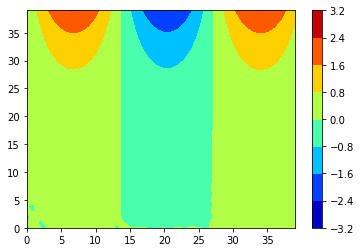

NameError: name 'train_labels' is not defined

In [20]:
import matplotlib.pyplot as plt

#output = model3(train_data.unsqueeze(1))


output = torch.zeros((399 ,1600)).to(device)
output = output.view(399 , 1600)

for i in range(4000):
  output = model3(output.unsqueeze(1))
  output = output.view(399 , 1600)

#u_solution , U_new = solve_poisson_fd(40 , 40 ,600)

plt.contourf(output[-1].reshape(40, 40).cpu().detach().numpy().T, cmap='jet')
plt.colorbar()
plt.show()

#plt.contourf(x, y, u_solution.cpu().detach().numpy().reshape(nx, ny), cmap='jet')
#plt.show()

plt.contourf(train_labels[-1].reshape(40, 40).cpu().detach().numpy(), cmap='jet')
plt.colorbar()
plt.show()  

In [63]:
def evaluation(U_exact , u_pred):
    M = 1000
    i = 0
    for u in U_exact:
        i += 1
        
        mse = torch.mean((u.flatten() - u_pred)**2)
        if mse < M:
            j = i
            u_s = u
            M = mse
            
            
    return u , M , j
u_solution , U_new = solve_poisson_fd(40 , 40 , 500)
u, mse , i = evaluation(U_new ,output[-1] )

print(i , mse ,U_new.shape ,output[-1].shape )
            

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 15.78 GiB total capacity; 13.23 GiB already allocated; 15.69 MiB free; 14.32 GiB reserved in total by PyTorch)

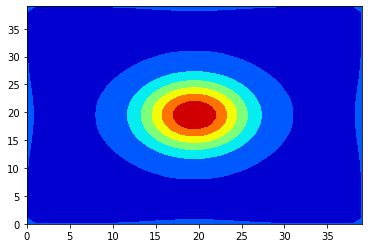

In [62]:
plt.contourf( U_new[-1].cpu().detach().numpy().reshape(nx, ny), cmap='jet')
plt.show()

torch.Size([50, 50])


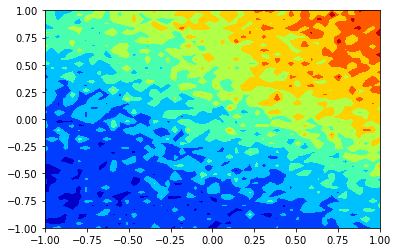

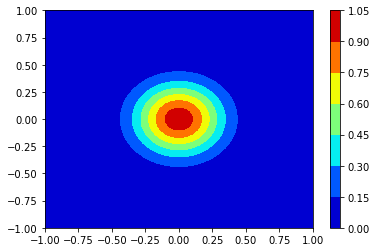

In [7]:
import matplotlib.pyplot as plt
x = torch.linspace(-1, 1, 50).to(device)
y = torch.linspace(-1, 1, 50).to(device)
x, y = torch.meshgrid(x, y)
u_exact = torch.exp(-10 * (x**2 + y**2)).to(device)
grid = torch.stack((x.flatten(),y.flatten()) ,dim = -1)
u = model2(grid.unsqueeze(1)).reshape(len(x) ,len(y))
mse = torch.mean((u- torch.exp(-10 * (x**2 + y**2)))**2 )
print(u.shape)
import matplotlib.pyplot as plt
plt.contourf(x.cpu().detach().numpy(), y.cpu().detach().numpy(), u.cpu().detach().numpy().reshape(50, 50), cmap='jet')
plt.show()


plt.contourf(x,y,u_exact,cmap='jet')
plt.colorbar()
plt.show()